In [12]:
from matplotlib import pyplot as plt
from IPython.display import Markdown as md
import os
from datetime import datetime
import pickle
from sklearn.metrics import classification_report
%matplotlib inline

In [13]:
ROOT = ".."

In [14]:
 movies_with_overviews_path = f'{ROOT}/data/processed/movies_with_overviews.pkl'
date_refreshed_unix = os.path.getmtime(movies_with_overviews_path)
date_refreshed = datetime.utcfromtimestamp(date_refreshed_unix).strftime('%Y-%m-%d %H:%M:%S')
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

with open(f'{ROOT}/data/processed/movies_with_overviews.pkl','rb') as f:
    movies_with_overviews=pickle.load(f)
with open(f'{ROOT}/data/processed/genre_id_to_name_dict.pkl','rb') as f:
    Genre_ID_to_name=pickle.load(f)
genre_list=sorted(list(Genre_ID_to_name.keys()))
    
num_movies = len(movies_with_overviews)

display(md('''# Data
Movie overviews and genres are scraped from TMDB. Our dataset was last refreshed at **{date_refreshed}**.

Report was generated **{now}**.

The data have **{num_movies}** movie overviews.

'''.format(date_refreshed=date_refreshed, num_movies=num_movies, now=now)))


# Data
Movie overviews and genres are scraped from TMDB. Our dataset was last refreshed at **2020-10-29 21:45:22**.

Report was generated **2020-10-29 14:54:48**.

The data have **1058** movie overviews.



# Project description
The current project aims to predict the genre of movie given the overview text that describes the movie. For example, the overview for *The Matrix* is as follows:
>Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.

From the above text, we would like to predict that the movie belongs to the "Action" and "Science Fiction" genres.

## Business object in context
We are an internet-based movie distributing company, _NetFlux_. For new movies and original content movies, we want to make sure our staff writes overviews that will represent the correct genre of the movie. This will make our recommender system work better and ultimately provide more insight for our users to what movies they want to see.



The distribution of the genres in these movies is shown in the chart below:

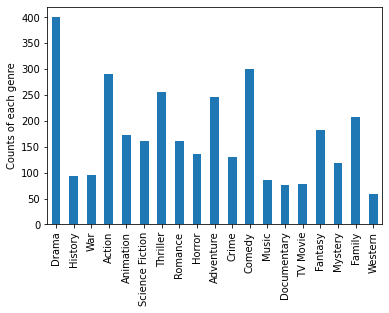

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
mwo = pd.DataFrame(movies_with_overviews)
genre_ids_series = mwo['genre_ids']
flat_genre_ids = [st for row in genre_ids_series for st in row]

flat_genre_names = [Genre_ID_to_name[id] for id in flat_genre_ids] 
genre_counts = Counter(flat_genre_names)
df = pd.DataFrame.from_dict(genre_counts, orient='index')
ax = df.plot(kind='bar')
ax.set_ylabel('Counts of each genre')
ax.legend().set_visible(False)


The top 10 movies in our dataset by popularity are listed below:

In [16]:
a=[print(x) for x in mwo.sort_values(by='popularity', ascending=False)['original_title'].head(10)]

Вий
Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan
Haute tension
呪怨2
Jurassic World
Frozen
Hacksaw Ridge
The Hobbit: The Battle of the Five Armies
Coraline
The Twilight Saga: Breaking Dawn - Part 2


# Models and Features

We are currently using the following models to train against the dataset with the associated feature engineering:
1. C-SVM
    - The overviews are using a **bag of words** model and have been vectorized and transformed using **TF_IDF**.
2. Naive Bayes
    - The overviews are using a **bag of words** model and have been vectorized with a **Count Vectorizer**.
3. Simple neural network (not deep)
    - The overviews were tokenized with a **white space tokenizer**. Stop words were removed. Overviews were treated as **bag of words**, which each word being converted to a vector, using the GoogleNews-vectors-negative300.bin model.  The **arithmetic mean** of the words represented the overview. Taking the top 3 genres predicted for each movie.



In [18]:
with open(f'{ROOT}/data/processed/genre_id_to_name_dict.pkl','rb') as f:
    genre_id_to_name=pickle.load(f)  

genre_names=list(genre_id_to_name.values())

In [21]:
import json

with open(f"{ROOT}/models/model_scores.json", "r") as f:
    scores = json.load(f)


In [ ]:
with open(f'{ROOT}/data/processed/target_test.pkl','rb') as f:
    target_test=pickle.load(f)

### Naive Bayes with Raw Bag of Word Features

#### Metrics for each genre

In [28]:
with open(f'{ROOT}/models/classifier_nb.pkl','rb') as f:
    classifnb = pickle.load(f)

with open(f'{ROOT}/data/processed/raw_count_features_test.pkl','rb') as f:
    raw_count_features_test=pickle.load(f)

predsnb=classifnb.predict(raw_count_features_test)
print (classification_report(target_test, predsnb, target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.55      0.54      0.55        48
      Adventure       0.41      0.58      0.48        31
      Animation       0.50      0.42      0.46        31
         Comedy       0.67      0.60      0.63        87
          Crime       0.50      0.34      0.41        29
    Documentary       0.65      0.64      0.64        61
          Drama       0.45      0.42      0.43        50
         Family       0.30      0.33      0.32        18
        Fantasy       0.25      0.08      0.12        12
        History       0.50      0.49      0.50        53
         Horror       0.52      0.44      0.48        25
          Music       0.59      0.71      0.65        14
        Mystery       0.55      0.50      0.52        34
        Romance       0.41      0.29      0.34        24
Science Fiction       0.33      0.50      0.40        14
       TV Movie       0.44      0.47      0.45        30
       Thriller       0.48    

#### Precision and Recall for the overall model

In [29]:
nb_scores = scores["naive_bayes"]

md('''
Precision: {prec_mean}

Recall: {rec_mean}
'''.format(prec_mean=nb_scores["prec"], rec_mean=nb_scores["rec"]))


Precision: 0.493351302785265

Recall: 0.4944182389937107


### C-SVM with TF-IDF features

#### Metrics for each genre

In [20]:
with open(f'{ROOT}/models/classifier_svc.pkl','rb') as f:
    svc_classifier=pickle.load(f)

with open(f'{ROOT}/data/processed/tfidf_count_features_test.pkl','rb') as f:
    tfidf_count_features=pickle.load(f)

predstfidf=svc_classifier.predict(tfidf_count_features)
print(classification_report(target_test, predstfidf, target_names=genre_names))


                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00        48
      Adventure       0.27      0.52      0.35        31
      Animation       0.00      0.00      0.00        31
         Comedy       0.58      0.57      0.58        87
          Crime       0.42      0.38      0.40        29
    Documentary       0.60      0.74      0.66        61
          Drama       0.00      0.00      0.00        50
         Family       0.44      0.39      0.41        18
        Fantasy       0.25      0.08      0.12        12
        History       0.46      0.55      0.50        53
         Horror       0.58      0.56      0.57        25
          Music       0.73      0.79      0.76        14
        Mystery       0.47      0.47      0.47        34
        Romance       0.35      0.38      0.36        24
Science Fiction       0.43      0.43      0.43        14
       TV Movie       0.40      0.27      0.32        30
       Thriller       0.47    

#### Precision and Recall for the overall model

In [24]:
svc_scores = scores["svc"]

md('''
Precision: {prec_mean}

Recall: {rec_mean}
'''.format(prec_mean=svc_scores["prec"], rec_mean=svc_scores["rec"]))


Precision: 0.48875786163522

Recall: 0.44017295597484274


### Simple Neural Network with Word2Vec features

In [30]:
import keras

with open(f'{ROOT}/data/processed/w2v_features_test.pkl','rb') as f:
    w2v_features=pickle.load(f)

w2v_nn = keras.models.load_model(f"{ROOT}/models/classifier_nn.h5")
with open(f'{ROOT}/models/mlb.pkl','rb') as f:
    mlb=pickle.load(f)

# score = w2v_nn.evaluate(w2v_features, target_test, batch_size=249)
Y_preds=w2v_nn.predict(w2v_features)

#### Precision and Recall for the overall model

In [32]:
nn_scores = scores["neural_network"]

md('''
Precision: {prec_mean}

Recall: {rec_mean}
'''.format(prec_mean=nn_scores["prec"], rec_mean=nn_scores["rec"]))


Precision: 0.5172955974842767

Recall: 0.5558176100628931
